## Overview

In the previous notebook, we learnt how to use [Xarray](http://xarray.pydata.org/) to work with gridded datasets. XArray is also well suited to work with georeferenced rasters - such as satellite imagery, population grids, or elevation data.[rioxarray](https://corteva.github.io/rioxarray/stable/index.html) is an extension of xarray that makes it easy to work with geospatial rasters.

In this section, we will take 4 individual SRTM tiles around the Mt. Everest region and merge them to a single GeoTiff using RasterIO. We will also use `matplotlib` to add labels to the final map using annonations.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install rioxarray

By convention, `rioxarray` is imported as `rxr`.

> Remember to always import `rioxarray` even if you are using sub-modules such as `merge_arrays`. Importing `rioxarray` activates the `rio` accessor which is required for all operations.

In [ ]:
import os
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import matplotlib.pyplot as plt

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

srtm_tiles = [
  'N27E086.hgt',
  'N27E087.hgt',
  'N28E086.hgt',
  'N28E087.hgt'
]

data_url = 'https://github.com/spatialthoughts/python-dataviz-web/releases/' \
  'download/srtm/'

for tile in srtm_tiles:
  url = '{}/{}'.format(data_url, tile)
  download(url)

## Rioxarray Basics

The `open_rasterio()` method from `rioxarray` is able to read any data source supported by. the [`rasterio`](https://rasterio.readthedocs.io/en/latest/) library. Let's open a single SRTM tile using `rioxarray`.

In [ ]:
filename = 'N28E087.hgt'
file_path = os.path.join(data_folder, filename)
rds = rxr.open_rasterio(file_path)

The result is a `xarray.DataArray` object.

In [ ]:
rds

You can access the pixel values using the `values` property which returns the array’s data as a numpy array.

In [ ]:
rds.values

A `xarray.DataArray` object also contains 1 or more `coordinates`. Each coordinate is a 1-dimensional array representing values along one of the data axes. In case of the 1-band SRTM elevation data, we have 3 coordinates - `x`, `y` and `band`.

In [ ]:
rds.coords

The raster metadata is stored in the [`rio`](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-rio-accessors) accessor. This is enabled by the `rioxarray` library which provides geospatial functions on top of `xarray`.

In [ ]:
print('CRS:', rds.rio.crs)
print('Resolution:', rds.rio.resolution())
print('Bounds:', rds.rio.bounds())
print('Width:', rds.rio.width)
print('Height:', rds.rio.height)

In [ ]:
band1 = rds.sel(band=1)
band1

## Plotting Multiple Rasters

Open each source file using `open_rasterio()` method and store the resulting datasets in a list.

In [ ]:
datasets = []
for tile in srtm_tiles:
    path = os.path.join(data_folder, tile)
    rds = rxr.open_rasterio(path)
    band = rds.sel(band=1)
    datasets.append(band)

You can visualize any `DataArray` object by calling `plot()` method. Here we create a subplot with 1 row and 4 columns. The `subplots()` method will return a list of Axes that we can use to render each of the source SRTM rasters. For plots with multiple columns, the Axes will be a nested list. To easily iterate over it, we can use `.flat` which returns a 1D iterator on the axes.

While plotting the data, we can use the `cmap` option to specify a color ramp. Here we are using the built-in *Greys* ramp. Appending **_r** gives us the inverted ramp with blacks representing lower elevation values. When plotting on multiple Axes, it is useful to specify `set_aspect('equal')` so the aspect raio of the plot is maintained even if there is not enough space.

In [ ]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,3)
for index, ax in enumerate(axes.flat):
    da = datasets[index]
    im = da.plot.imshow(ax=ax, cmap='Greys_r')
    filename = srtm_tiles[index]
    ax.set_title(filename)
    ax.set_aspect('equal') # maintain aspect ratio

plt.tight_layout()
plt.show()

## Merging Rasters

Now that you understand the basic data structure of *xarray* and the *rio* extension, let's use it to process some data. We will take 4 individual SRTM tiles and merge them to a single GeoTiff. You will note that `rioxarray` handles the CRS and transform much better - taking care of internal details and providing a simple API.

We will use the `merge_arrays()` method from the `rioxarray.merge` module to merge the rasters. We can also specify an optional `method` that controls how overlapping tiles are merged. Here we have chosen `first` which takes the value of the first raster in the overlapping region.

Reference: [`merge_arrays()`](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray.merge.merge_arrays)

In [ ]:
merged = merge_arrays(datasets, method='first')
merged

We can now visualize the merged raster.

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
merged.plot.imshow(ax=ax, cmap='Greys_r')
ax.set_title('merged')
plt.show()

We can save the resulting raster in any format supported by GDAL using the `to_raster()` method. Let's save this as a [Cloud-Optimized GeoTIFF (COG)](https://gdal.org/drivers/raster/cog.html).

In [ ]:
output_file = 'merged.tif'
output_path = os.path.join(output_folder, output_file)
merged.rio.to_raster(output_path, driver='COG')

## Annotating Plots

Sometime it is helpful to add annotations on your plot to highlight a feature or add a text label. In this section we will learn how to use the annotate the DEM to show the location and elevation of Mt. Everest.

First, we locate the coordinates of the maximum elevation in the `merged` DataArray using the `max()` function. We can then use `where()` function to filter the elements where the value equals the maximum elevation. Lastly, we run `squeeze()` to remove the extra empty dimension from the result.

References:

* [xarray.DataArray.max](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.max.html)
* [xarray.DataArray.where](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html)

In [ ]:
max_da = merged.where(merged==merged.max(), drop=True).squeeze()
max_da

We now extract the x,y coordinates and the value of the maximum elevation.

In [ ]:
max_x = max_da.x.values
max_y = max_da.y.values
max_elev = int(max_da.values)
print(max_x, max_y, max_elev)

Now we plot the `merged` raster and annotate it using the `annotate()` function.

Reference: [matplotlib.pyplot.annotate
](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html)

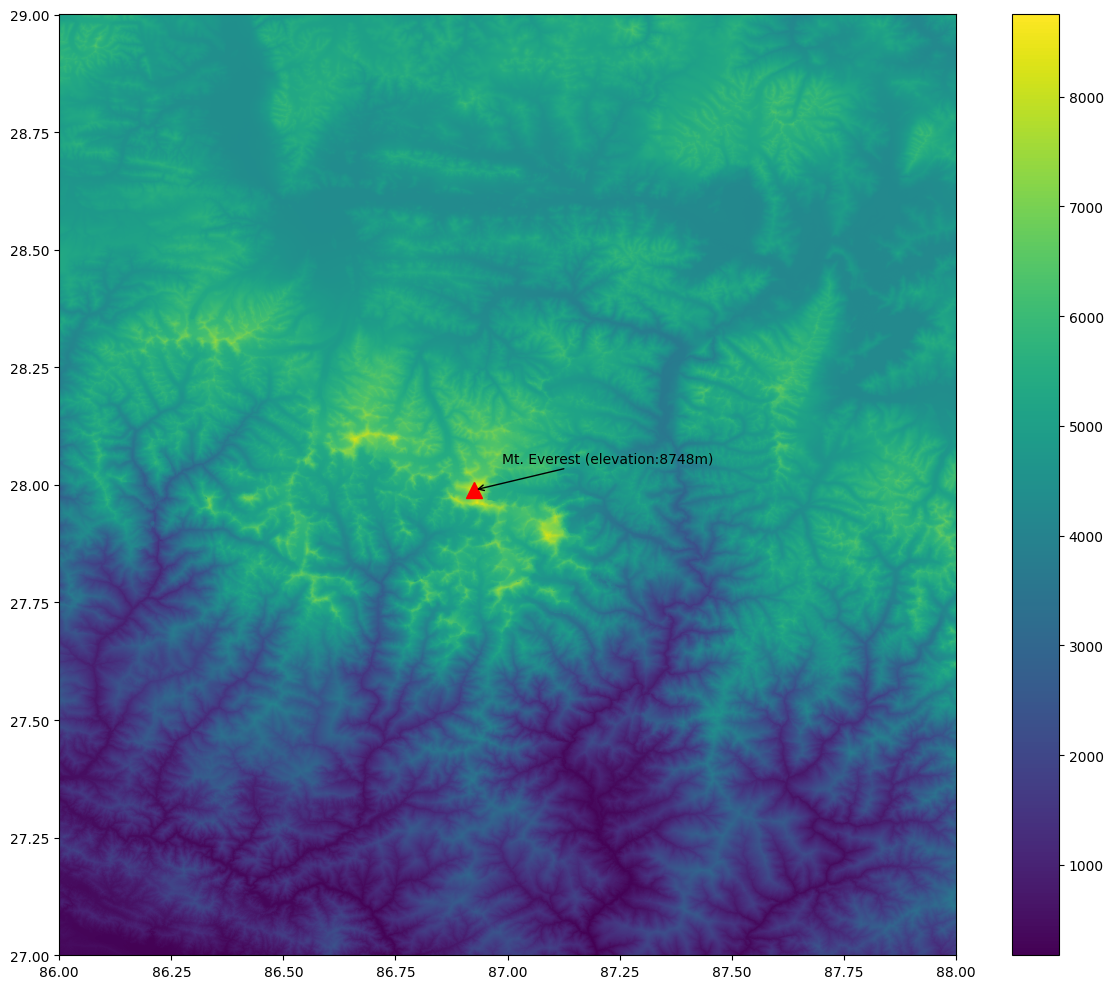

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 10)
merged.plot.imshow(ax=ax, cmap='viridis', add_labels=False)
ax.plot(max_x, max_y, '^r', markersize=11)
ax.annotate('Mt. Everest (elevation:{}m)'.format(max_elev),
            xy=(max_x, max_y), xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops={'arrowstyle':'->', 'color':'black'}
            )
plt.tight_layout()
plt.show()

## Exercise

Add contours to the elevation plot below.

<img src='https://courses.spatialthoughts.com/images/python_dataviz/contours.png' width=600/>

Start with the code snippet below and use the [`xarray.plot.contour`](https://docs.xarray.dev/en/stable/generated/xarray.plot.contour.html) function to render the contours

Hint: Use the options `colors=white` and `levels=10`.

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
merged.plot.imshow(
    ax=ax,
    cmap='viridis',
    add_labels=False,
    add_colorbar=False)

ax.set_axis_off()
plt.tight_layout()
plt.show()